# Tissue R1-Oxygen Model Notebook

## Imports

In [208]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('ggplot')
import scipy
import math
import random
from scipy.optimize import least_squares
import pandas as pd
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn.model_selection import train_test_split
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn
from sklearn.metrics import mean_squared_error

## 1. Function for calculating SO2 along capillary from OEF and CaO2

Rieger 2015: 
The total concentration of oxygen c is given by

$c= \alpha P + Hc_{0}S(P)$

Where 
H is hematocrit
c0 is the concentration of oxygen in the RBCs at full saturation

$\alpha = \alpha_{p} + H \alpha_{RBC}$

$\alpha$ is the effective solubility in blood and $ \alpha_{p}$ and $\alpha_{RBC}$ are the solubility in plasma and RBCs, respectively. 

and $S(P)=\frac{P^n}{P^n+P^n_{50}}$


From https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2901984/#b38:

$ScapO2=SaO2*(1-\frac{OEF}{2})$

$OEF=\frac{CaO2-CvO2}{CaO2}$

$c= \alpha P + Hc_{0}S(P)$

#### INPUT VARIABLES: PaO2, OEF
#### CONSTANTS: L, Nr, P50, n
#### OUTPUTS: SO2 along capillary, PO2 along capillary



In [209]:
def SO2cap_from_OEF(PaO2,OEF):
    
    SaO2=(PaO2**n)/((PaO2**n)+P50**n)

    halfL=L/2
    length=np.linspace(0,L*10000,100)
    z=length/10000
    
    Scapmean=SaO2*(1-(OEF/2))
    slope=(Scapmean-SaO2)/halfL
    so2_along_cap=SaO2+slope*z
    
    po2_along_cap=((so2_along_cap*(P50**n))/(1-so2_along_cap))**(1/n)

    return(so2_along_cap,po2_along_cap)


# so2_along_cap,po2_along_cap=SO2cap_from_OEF(PaO2,OEF)




## 2. Function for calculating $R_t$ (Krogh tissue radius) from blood volume in the voxel

This is a rough approximation and there's probably a better way to do this, but here's what I've managed to do:

First find Ncap per 1$mm^3$ voxel from blood volume: 

$Vcap=\pi R_c^2L$

$BV=\frac{Ncap*Vcap}{Vvoxel}$

$BV=\frac{Ncap*\pi*R_c^2*L}{Vvoxel}$

$\frac{BV*Vvoxel}{L*\pi*R_c^2}=Ncap$

Then, take a cross section. If we assume evenly spaced capillaries along x and y, the number of capillaries along 1 dimension is $\sqrt{Ncap}$. 

Therefore for a 1mm voxel:

$Voxel_{width}=(2*R_t + 2*R_c)*\sqrt{Ncap}$

$\frac{Voxel_{width}}{2*(\sqrt{Ncap})} - R_c = R_t$

#### INPUT VARIABLES: % Blood volume (0-1 fraction)
#### CONSTANTS: Rc, Voxel width and volume (1mm^3)
#### OUTPUTS: Rt

In [210]:
def Rt_from_BV(BV,Rc):
    voxel_volume=1e-9 #(m^3)= 1mm^3
    Rc = 5e-6; # [m] capillary radius - 5 to 10 micrometres (μm) in diameter
    
    Ncap=(BV*voxel_volume)/(L*math.pi*(Rc**2))
    
    voxel_width=voxel_volume**(1/3)
    
    Rt=(voxel_width)/(2*(np.sqrt(Ncap)))
    
    return(Rt)
    
# Rt=Rt_from_BV(BV,Rc)

## 3. Function for calculating M0 (oxygen consumption rate) from SO2 slope

$\frac{SaO2*OEF*Hct*CHb*v}{L*(Rt^2-Rc^2)}=M_0	$

#### INPUT VARIABLES: SaO2, SO2_along_cap, OEF, Rt
#### CONSTANTS: L, Nr, P50, n, Hct, CHb, v, Rc
#### OUTPUTS: M0



In [223]:
def calc_M0(so2_along_cap,OEF):
    SaO2=np.max(so2_along_cap)
    M0=(SaO2*OEF*Hct*CHb*v)/(L*(Rt**(2)+Rc**(2)))
    
    
    return(M0)

# M0=calc_M0(so2_along_cap,OEF,Rt,L,Nr,P50,n,Hct,CHb,v,Rc)

## 4. Function for Calculating Tissue PO2 ("Into Tissue" Dimension), including PO2-dependent M0
Paraphrased from ['Theoretical Models of Microvascular Oxygen Transport to Tissue'](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3057578/) by Daniel Goldman:

The Krogh-Erlang solution has the following assumptions:

- Tissue O2 consumption is constant and uniform
- Tissue PO2 at the capillary wall equals average capillary pO2 (no IVR)
- Tissue O2 solubility and diffusivity are uniform
- Axial (or longitudinal) diffusion of O2 is not significant 
- All important microvascular O2 transport phenomena are steady-state
- All capillaries are parallel, unbranched, and equally spaced
- All capillaries recieve equal convective O2 supply
- Capillaries are the only microvessels that play a role in O2 transport to tissue

For steady state pO2 in the tissue cylinder and a given capillary PO2, the Krogh-Erlang solution is:

$ P(r) = P_{cap} + \frac{M_0}{4K}(r^2-R^2_c) - \frac{M_0 R_t^2}{2K} ln\frac{r}{R_{cap}} $

Where:
- P is the pO2 at r in the tissue 
- P=Pcap at R=Rcap
- r is the radial coordinate
- K is the Krogh diffusion constant K=Dk, D is the tissue O2 diffusivity and k is the tissue O2 solubility 
- M0 is the tissue O2 consumption rate
- Rcap is capillary radius 
- Rt is tissue radius


### Modifications to Krogh Model - O2 Consumption 

Paraphrased from ['Theoretical Models of Microvascular Oxygen Transport to Tissue'](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3057578/) by Daniel Goldman:

An important modification made to the Krogh cylinder model above is the assumption of pO2-dependent tissue O2 consumption. PO2-Dependent O2 consumption can be added to the model.
Experiments suggest that the local tissue O2 consumption rate is found to be approximately constant for tissue pO2 above a certain value, Pcrit; below this value O2 consumption drops off sharply to zero. Therefore, in order to study situations in which hypoxia is expected (which is relevant to our tumour tissue R1 model here), a mathematical model of PO2-dependent consumption is required. The most common model (Michaelis-Menten) uses first-order kinetics and gives the following equilibirum O2 consumption rate:

$ M(P) =\frac{M_0*P}{P + P_{crit}}$

where:
- P is the tissue po2
- M0 is the maximum local O2 consumption rate 

Note: "This model does not keep O2 consumption strictly constant for P>Pcrit, but gives a reasonable approximation to the actual behaviour and is more convenient computationally than the zeroth-order (on-off) model. Although M0 depends on the particular tissue and conditions being considered, Pcrit is usually taken to be in the range of 0.5-1.0mmHg."

#### INPUT VARIABLES: PO2 along capillary, M0, Rt (all already calculated)
#### CONSTANTS: K, Rc, Nr,Nz
#### OUTPUTS: 2D matrix of PO2 into the tissue & along capillary "po2_r_z_list", and the mean PO2 in the tissue

In [212]:
def po2_into_tissue(po2_along_cap):

    r_list = np.linspace(Rc,Rt,Nr)
    pcap_list=po2_along_cap
    po2_r_z_list=np.zeros((Nr,Nz))

    for i in range(0,Nz):
        po2_cap=pcap_list[i]


        for j in range(0,Nr):
            r=r_list[j]

            M=(M0*po2_cap)/(po2_cap+Pcrit)
            po2_r=po2_cap+((M/(4*K))*(r**(2)-Rc**(2))) - ((M*Rt**2)/(2*K))*(math.log((r/Rc))) # that log is actually ln
            po2_r_z_list[i,j]=po2_r
            
    mean_Tpo2=np.mean(po2_r_z_list)

    return(po2_r_z_list,mean_Tpo2)

# po2_r_z_list,mean_Tpo2=po2_into_tissue(po2_along_cap,M0,Rt,Rc,Nr,Nz,K)

## 5. Function for estimating r1Ox with respect to B0

$ r1Ox = \frac{C1}{C2+C3*B0^2} + C4 + TempC*T$


#### INPUT VARIABLE: B0

#### CONSTANTS: Temp,C1,C2,C3,C4,TempC

#### OUTPUT: r1Ox for tissue

In [221]:
def r1Ox_func(B0,Temp,C1,C2,C3,C4,TempC):
    r1Ox_tissue_unconverted=C1/(C2+(C3)*(B0**2)) +C4 +TempC*Temp 
    r1Ox_tissue=r1Ox_tissue_unconverted*10**(-4)
    return(r1Ox_tissue)

# r1Ox_tissue=r1Ox_func(B0,Temp,C1,C2,C3,C4,TempC)

# can remove the temperature part of this


## 6. Function for calculating ΔR1Tissue from ΔPO2

$\Delta R1_{tissue}=r1Ox*\Delta PO2$


#### INPUT VARIABLES: ΔPO2 in tissue (PO2oxygen-PO2air), r1Ox_tissue
#### CONSTANTS: none
#### OUTPUTS: ΔR1 in tissue (R1oxygen-R1air)

In [214]:
def calc_delta_R1_tissue(delta_po2_tissue,r1Ox_tissue):
    delta_R1_tissue=r1Ox_tissue*delta_po2_tissue
    
    return(delta_R1_tissue)

# delta_R1_tissue=calc_delta_R1_tissue(delta_po2,r1Ox_tissue)

## 8.  Function for calculating ΔR1blood 

$ΔR1blood = R1blood_{oxygen} - R1blood_{air}$


### Inner Function for estimating R1blood w.r.t B0, Hct, and PO2

$ R1blood(Hct,PO2) = fe*(R1eox + r1deoxhyHb*[Hb]*(1-\frac{PO2^n}{PO2^n + P50^n})) + (1-fe)*(R1p+r1pox*PO2)$

Where:

$fe=\frac{0.7*Hct}{(0.7*Hct)+0.95*(1-Hct)}$

$R1eox(B0)=bR1eox+mR1eox*B0$

$r1deoxyHb(B0)=br1deoxyHb+mr1deoxyHb*B0$

$R1p(B0)=bR1p+mR1p*B0$

$r1pox(B0,Hct)=br1pox+mr1pox*B0+mr1poxHct*Hct$



#### INPUT VARIABLES: PO2 oxygen, PO2 air

#### CONSTANTS: Hct, B0, Hb, n, P50, bR1eox,mR1eox,br1deoxyHb,mr1deoxyHb,bR1p,mR1p,br1pox,mr1pox,mr1poxHct 

#### OUTPUT: ΔR1blood (oxygen-air)

In [215]:
def calc_delta_R1_blood(po2_oxygen,po2_air,Hct,B0,Hb,n,P50,bR1eox,mR1eox,br1deoxyHb,mr1deoxyHb,bR1p,mR1p,br1pox,mr1pox,mr1poxHct):


    def R1blood_func(po2,Hct,B0,Hb,n,P50,bR1eox,mR1eox,br1deoxyHb,mr1deoxyHb,bR1p,mR1p,br1pox,mr1pox,mr1poxHct):

        fw=(0.7*Hct)/((0.7*Hct)+0.95*(1-Hct))
        R1eox=bR1eox+mR1eox*B0
        r1deoxyHb=br1deoxyHb+mr1deoxyHb*B0
        R1p=bR1p+mR1p*B0
        r1pox=br1pox+mr1pox*B0+mr1poxHct*Hct
        so2=(po2**n)/((po2**n)+(P50**n))

        R1_blood_result=fw*(R1eox + (r1deoxyHb*Hb*(1-so2))) + (1-fw)*(R1p+r1pox*po2)
        
        return(R1_blood_result)
    
    R1blood_air=R1blood_func(po2_air,Hct,B0,Hb,n,P50,bR1eox,mR1eox,br1deoxyHb,mr1deoxyHb,bR1p,mR1p,br1pox,mr1pox,mr1poxHct)
    R1blood_oxygen=R1blood_func(po2_oxygen,Hct,B0,Hb,n,P50,bR1eox,mR1eox,br1deoxyHb,mr1deoxyHb,bR1p,mR1p,br1pox,mr1pox,mr1poxHct)
    
    delta_R1_blood=R1blood_oxygen-R1blood_air
    
    return(delta_R1_blood)
    

    

# R1_blood_result=R1blood_func(po2,Hct,B0,Hb,n,P50,bR1eox,mR1eox,br1deoxyHb,mr1deoxyHb,bR1p,mR1p,br1pox,mr1pox,mr1poxHct)

# delta_R1_blood=calc_delta_R1_blood(po2_oxygen,po2_air,Hct,B0,Hb,n,P50,bR1eox,mR1eox,br1deoxyHb,mr1deoxyHb,bR1p,mR1p,br1pox,mr1pox,mr1poxHct)


## 9. Function for Calculating ΔR1voxel

$ΔR1voxel=(0.5*BV)*ΔR1arterial +(1-BV)*ΔR1tissue +(0.5*BV)*ΔR1venous$


#### INPUT VARIABLES: $ΔR1blood_{arterial}$, $ΔR1blood_{venous}$, ΔR1tissue, Blood volume (BV)

#### CONSTANTS:  none

#### OUTPUT: ΔR1voxel (oxygen-air)

In [216]:
def calc_delta_R1_voxel(delta_R1_blood_arterial,delta_R1_blood_venous,delta_R1_tissue,BV):
        
        delta_R1_voxel=(0.5*BV)*delta_R1_blood_arterial+ (0.5*BV)*delta_R1_blood_venous + (1-BV)*delta_R1_tissue
        return(delta_R1_voxel)
    
# delta_R1_voxel=calc_delta_R1_voxel(delta_R1_blood_arterial,delta_R1_blood_venous,delta_R1_tissue,BV)
    


## Set Constants

In [217]:
# constants
n= 2.7
Hb= 5.15
bR1eox= 1.1538
mR1eox= -0.06747
br1deoxyHb= 0.16038
mr1deoxyHb= -0.016139
bR1p= 0.40656
mR1p= -0.00565
br1pox= 0.0004227
mr1pox= -2.925e-05
mr1poxHct= 0.00033577

C1=25.35
C2=5.24
C3=10.39
C4=0.845
TempC=0.0323

# can change these
Hct=0.45 
Temp=37 # degrees C, body temp
P50=37 # average between human and animals

In [218]:
# Constants that I'm sure about

Hct=0.45
Pcrit=3 #or 0.35 mmHg 
P50=37 #mmHg

# Constants that I'm Semi-sure about

Rc = 5e-6; # [m] capillary radius - 5 to 10 micrometres (μm) in diameter
L = 0.0006; # [m] Length of capillary segment the average length of a capillary is about ~600 microns
Rt = 1e-5; # m| Tissue Cylinder radius

# Constants that I'm NOT sure about

v = 0.00114 # capillary velocity [m/s]
D = 2.41e-9 # [m^2/s] diffusivity of O2 in tumour tissue 
k = 1.5e-5 # [M/mmHg] solubility of O2 in tumour tissue 
K = D*k

M0 = 0.1  # mol/m^3/s
# 0.002M0 is the maximum local O2 consumption rate
# tumour tissue: 0.0122 mol/m^3/s
# normal tissue: 0.00197 mol/m^3/s

# from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3899881/
# For the DLD1 spheroids studied, the consumption rate for all spheroids studied was 
# approximately constant at a = 7.29 ± 1.4 × 10−7 m3 kg−1 s−1, 
# in good agreement with previous data from similar approaches [26].

# tumour tissue O2 consumption rate [M/s] 
# https://www.tandfonline.com/doi/pdf/10.3109/02841869509093981
# The maximal consumption rate is = 2.4 cm3 O2/100 g/min, at the upper end 
# of the range observed experimentally in this preparation (10).

CHb= 0.008976 #molO2/m^3
# 15 gHb/dL of blood x 1.34 mLO2 /gHb = 20.1 mlO2/dL of blood
# 150 gHb/L of blood x 1.34 mLO2 /gHb = 201 mlO2/L of blood

# 22392.44 mL O2 = 1 mol O2, therefore 1.34 mL O2 = 0.00005984 mol O2

# 150 gHb/L of blood x 0.00005984 molO2 /gHb = 0.008976 molO2/L of blood

# 0.008976 molO2/L = 8.976 molO2/m^3

# The oxygen-carrying capacity of the blood is calculated as the concentration of hemoglobin (in g / dL blood) 
# times 1.34 mL O2 / g Hb. In a healthy person, with a hemoglobin concentration of 15 g / dL blood, 
# the oxygen carrying capacity is 20.1 mL O2 / dL blood#  

#"The Hüfner constant
#The oxygen binding capacity of haemoglobin (BO2) is the amount of 
# oxygen in millilitres carried by each gram of haemoglobin, and 
# is commonly referred to as Hüfner's constant. Over many years, 
# different values have been obtained for this constant, with those 
# found experimentally consistently lower than the theoretical value. 
# Based on the molecular weight of haemoglobin, and the fact that one 
# mole of haemoglobin binds four moles of oxygen, a theoretical value 
# for BO2 of 1.39 ml g−1 is easily obtained. However, in vivo experiments 
# produce values anywhere between 1.31 and 1.37 ml g−1. This variation is now 
# believed to result from the presence of small amounts of other forms of 
# haemoglobin which are relatively poor carriers of oxygen, for example, 
# HbA2, methaemoglobin, and carboxyhaemoglobin. If the proportion of these 
# forms of haemoglobin are determined using a co-oximeter and excluded from the 
#calculations, the theoretical value of 1.39 ml g−1 is reliably obtained.3
# https://academic.oup.com/bjaed/article/12/5/251/289041 


# Call the functions
this is where the action happens

In [222]:
## Variables you can alter:
OEF=0.32
BV=0.01

PaO2_air=90 # mmHg
PaO2_ox=400 # mmHg

def monster_R1voxel_func(BV,PaO2_air,PaO2_ox,OEF)
###################################################

    # calculate Rt
    Rt=Rt_from_BV()

    ###################################################
    # calculate so2 along capillary ON AIR
    so2_along_cap_air,po2_along_cap_air=SO2cap_from_OEF(PaO2_air)

    # calculate so2 along capillary ON OXYGEN
    so2_along_cap_ox,po2_along_cap_ox=SO2cap_from_OEF(PaO2_ox)

    # calculate PvO2 on air and oxygen
    PvO2_air=np.min(po2_along_cap_air)
    PvO2_ox=np.min(po2_along_cap_ox)

    ###################################################

    # calculate M0 - uses only ON AIR values
    M0=calc_M0(so2_along_cap_air)

    ###################################################

    # calculate mean po2 in tissue ON AIR
    po2_r_z_list_air,mean_Tpo2_air=po2_into_tissue(po2_along_cap_air)

    # calculate mean po2 in tissue ON OXYGEN
    po2_r_z_list_ox,mean_Tpo2_ox=po2_into_tissue(po2_along_cap_ox)

    # calculate DELTA PO2 of TISSUE (oxygen - air)
    delta_po2_tissue=mean_Tpo2_ox-mean_Tpo2_air

    ###################################################

    # calculate r1Ox for tissue
    r1Ox_tissue=r1Ox_func()

    # calculate ΔR1tissue
    delta_R1_tissue=calc_delta_R1_tissue(delta_po2_tissue,r1Ox_tissue)

    ###################################################

    # calculate ΔR1arterial
    delta_R1_blood_arterial=calc_delta_R1_blood(PaO2_air,PaO2_ox)

    # calculate ΔR1venous
    delta_R1_blood_venous=calc_delta_R1_blood(PaO2_air,PaO2_ox)

    ###################################################

    delta_R1_voxel=calc_delta_R1_voxel(delta_R1_blood_arterial,delta_R1_blood_venous,delta_R1_tissue)


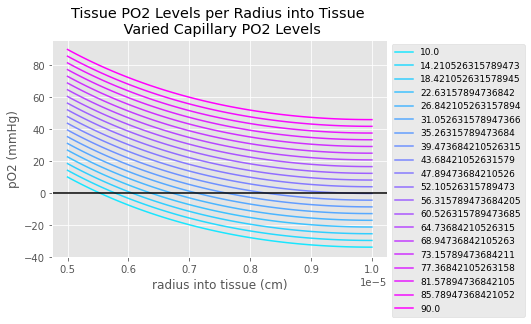

In [9]:
r_list = np.linspace(Rc,Rt,100)
po2_list=np.zeros(100)
pcap_list=np.linspace(10,90,20)

fig = plt.figure()
ax = fig.add_subplot(111)
for j in range(0,len(pcap_list)):
    for i in range(0,len(r_list)):
        r=r_list[i]
        po2_c=pcap_list[j]
        po2_r=po2_c+((M0/(4*K))*(r**(2)-Rc**(2))) - ((M0*Rt**2)/(2*K))*(math.log((r/Rc))) # that log is actually ln
        po2_list[i]=po2_r

    
    plt.plot(r_list,po2_list,label=po2_c)


colormap = plt.cm.cool #nipy_spectral, Set1,Paired   
colors = [colormap(i) for i in np.linspace(0.1, 1,len(ax.lines))]
for i,j in enumerate(ax.lines):
    j.set_color(colors[i])
plt.axhline(color='k')

plt.title('Tissue PO2 Levels per Radius into Tissue \n Varied Capillary PO2 Levels')
plt.xlabel('radius into tissue (cm)')
plt.ylabel('pO2 (mmHg)')
plt.legend(fontsize=9,bbox_to_anchor=(1, 1))

## Modifications to Krogh Model - O2 Consumption 

Paraphrased from ['Theoretical Models of Microvascular Oxygen Transport to Tissue'](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3057578/) by Daniel Goldman:

An important modification made to the Krogh cylinder model above is the assumption of pO2-dependent tissue O2 consumption. PO2-Dependent O2 consumption can be added to the model.
Experiments suggest that the local tissue O2 consumption rate is found to be approximately constant for tissue pO2 above a certain value, Pcrit; below this value O2 consumption drops off sharply to zero. Therefore, in order to study situations in which hypoxia is expected (which is relevant to our tumour tissue R1 model here), a mathematical model of PO2-dependent consumption is required. The most common model (Michaelis-Menten) uses first-order kinetics and gives the following equilibirum O2 consumption rate:

$ M(P) =\frac{M_0*P}{P + P_{crit}}$

where:
- P is the tissue po2
- M0 is the maximum local O2 consumption rate 

Note: "This model does not keep O2 consumption strictly constant for P>Pcrit, but gives a reasonable approximation to the actual behaviour and is more convenient computationally than the zeroth-order (on-off) model. Although M0 depends on the particular tissue and conditions being considered, Pcrit is usually taken to be in the range of 0.5-1.0mmHg."

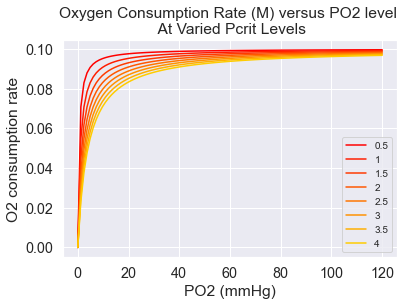

In [138]:
Mlist=np.zeros(100)
po2_list=np.linspace(120,0,100)
M0 = 0.1
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
sns.set(font_scale=1.3)

for j in [0.5,1,1.5,2,2.5,3,3.5,4]:
    Pcrit=j
    for i in range(0,len(po2_list)):
        po2_r=po2_list[i]
        M=(M0*po2_r)/(po2_r+Pcrit)
        Mlist[i]=M

    plt.plot(po2_list,Mlist,label=Pcrit)

colormap = plt.cm.autumn #nipy_spectral, Set1,Paired   
colors = [colormap(i) for i in np.linspace(0, 0.8,len(ax2.lines))]
for i,j in enumerate(ax2.lines):
    j.set_color(colors[i])


plt.title('Oxygen Consumption Rate (M) versus PO2 level \n At Varied Pcrit Levels')
plt.xlabel('PO2 (mmHg)')
plt.ylabel('O2 consumption rate')

plt.legend(fontsize=10)
    

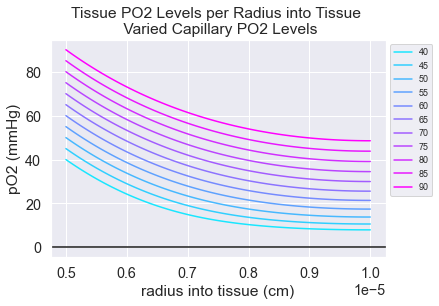

In [125]:
r_list = np.linspace(Rc,Rt,100)
po2_list=np.zeros(100)
pcap_list=[40,45,50,55,60,65,70,75,80,85,90]
Mlist=np.zeros((100,20))

fig = plt.figure()
ax = fig.add_subplot(111)

for j in range(0,len(pcap_list)):
    for i in range(0,len(r_list)):
        r=r_list[i]
        po2_c=pcap_list[j]
        
        if i==0:
            M=(M0*po2_c)/(po2_c+Pcrit)
            po2_r=po2_c+((M/(4*K))*(r**(2)-Rc**(2))) - ((M*Rt**2)/(2*K))*(math.log((r/Rc))) # that log is actually ln

        if i>0:
            if po2_r>Pcrit:
                M=(M0*po2_r)/(po2_r+Pcrit)
                po2_r=po2_c+((M/(4*K))*(r**(2)-Rc**(2))) - ((M*Rt**2)/(2*K))*(math.log((r/Rc))) # that log is actually ln
            if po2_r<=Pcrit:
                po2_r=Pcrit
        po2_list[i]=po2_r

    plt.plot(r_list,po2_list,label=po2_c)


colormap = plt.cm.cool #nipy_spectral, Set1,Paired   
colors = [colormap(i) for i in np.linspace(0.1, 1,len(ax.lines))]
for i,j in enumerate(ax.lines):
    j.set_color(colors[i])
plt.axhline(color='k')

plt.title('Tissue PO2 Levels per Radius into Tissue \n Varied Capillary PO2 Levels')
plt.xlabel('radius into tissue (cm)')
plt.ylabel('pO2 (mmHg)')
plt.legend(fontsize=9,bbox_to_anchor=(1, 1))

### Equation for PO2 ("Along the Capillary" Dimension)
Paraphrased from ['Theoretical Models of Microvascular Oxygen Transport to Tissue'](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3057578/) by Daniel Goldman:

To find the given Pcap along the capillary direction z, following equation can be used to calculate the SO2. 

$SO2(z)= SO2_a - \frac{M_0*(R^2_t-R^2_c)}{Hct*CHb*v}*z$

where: 
- Hct is the hematocrit
- CHb is the O2-binding capacity of the RBC Hb - CHb is the product of the RBC hemoglobin concentration and the O2 binding capacity of Hb
- v is RBC velocity

The invertible form of the Hb-O2 dissociation curve (e.g., the Hill equation) can be used as Pcap(z)=P(S(z)) to find the Pcap to use in the solution for the tissue pO2:

$SO2(P)=\frac{P^n}{P^n+P^n_{50}}$

rearranged:
$SO2(P)=\frac{P^n}{P^n+P^n_{50}}$

$P = \sqrt[n]{\frac{(P^n_{50}*SO2)}{1-SO2}}$

where:
- P the PO2 inside RBC
- P50 is the half-saturation PO2 
- n is the Hill exponent

P50 and n are found by fitting this equation to experimental data, with typical values of P50=37mmHg and n=2.7 for a rat (not sure of human values yet).

In [58]:
# Constants that I'm sure about

Hct=0.45
Pcrit=3 #or 0.35 mmHg 
P50=37 #mmHg

# Constants that I'm Semi-sure about

Rc = 5e-6; # [m] capillary radius - 5 to 10 micrometres (μm) in diameter
L = 0.0006; # [m] Length of capillary segment the average length of a capillary is about ~600 microns
Rt = 1e-5; # m| Tissue Cylinder radius

D = 2.41e-9 # [m^2/s] diffusivity of O2 in tumour tissue 
k = 1.5e-5 # [M/mmHg] solubility of O2 in tumour tissue 
K = D*k

# Constants that I'm NOT sure about

v = 0.00114 # capillary velocity [m/s]

M0 = 0.0122  # mol/m^3/s
#M0 = 0.0000122  # molO2/L/s

# 0.002M0 is the maximum local O2 consumption rate
# tumour tissue: 0.0122 mol/m^3/s
# normal tissue: 0.00197 mol/m^3/s

# from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3899881/
# For the DLD1 spheroids studied, the consumption rate for all spheroids studied was 
# approximately constant at a = 7.29 ± 1.4 × 10−7 m3 kg−1 s−1, 
# in good agreement with previous data from similar approaches [26].
 
# https://www.tandfonline.com/doi/pdf/10.3109/02841869509093981
# The maximal consumption rate is = 2.4 cm3 O2/100 g/min, at the upper end 
# of the range observed experimentally in this preparation (10).
# 2.4 cm^3 = 2.4e-6 m^3 = 0.0000024 m^3 O2 /100 g/min


CHb= 8.976 #molO2/m^3
# 15 gHb/dL of blood x 1.34 mLO2 /gHb = 20.1 mlO2/dL of blood
# 150 gHb/L of blood x 1.34 mLO2 /gHb = 201 mlO2/L of blood

# 22392.44 mL O2 = 1 mol O2, therefore 1.34 mL O2 = 0.00005984 mol O2

# 150 gHb/L of blood x 0.00005984 molO2 /gHb = 0.008976 molO2/L of blood

# 0.008976 molO2/L = 8.976 molO2/m^3

# The oxygen-carrying capacity of the blood is calculated as the concentration of hemoglobin (in g / dL blood) 
# times 1.34 mL O2 / g Hb. In a healthy person, with a hemoglobin concentration of 15 g / dL blood, 
# the oxygen carrying capacity is 20.1 mL O2 / dL blood#  

#"The Hüfner constant
#The oxygen binding capacity of haemoglobin (BO2) is the amount of 
# oxygen in millilitres carried by each gram of haemoglobin, and 
# is commonly referred to as Hüfner's constant. Over many years, 
# different values have been obtained for this constant, with those 
# found experimentally consistently lower than the theoretical value. 
# Based on the molecular weight of haemoglobin, and the fact that one 
# mole of haemoglobin binds four moles of oxygen, a theoretical value 
# for BO2 of 1.39 ml g−1 is easily obtained. However, in vivo experiments 
# produce values anywhere between 1.31 and 1.37 ml g−1. This variation is now 
# believed to result from the presence of small amounts of other forms of 
# haemoglobin which are relatively poor carriers of oxygen, for example, 
# HbA2, methaemoglobin, and carboxyhaemoglobin. If the proportion of these 
# forms of haemoglobin are determined using a co-oximeter and excluded from the 
#calculations, the theoretical value of 1.39 ml g−1 is reliably obtained.3
# https://academic.oup.com/bjaed/article/12/5/251/289041

[0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9
 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9
 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9
 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9
 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9
 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9]
[0.00000000e+00 6.06060606e-06 1.21212121e-05 1.81818182e-05
 2.42424242e-05 3.03030303e-05 3.63636364e-05 4.24242424e-05
 4.84848485e-05 5.45454545e-05 6.06060606e-05 6.66666667e-05
 7.27272727e-05 7.87878788e-05 8.48484848e-05 9.09090909e-05
 9.69696970e-05 1.03030303e-04 1.09090909e-04 1.15151515e-04
 1.21212121e-04 1.27272727e-04 1.33333333e-04 1.39393939e-04
 1.45454545e-04 1.51515152e-04 1.57575758e-04 1.63636364e-04
 1.69696970e-04 1.75757576e-04 1.81818182e-04 1.87878788e-04
 1.93939394e-04 2.00000000e-04 2.06060606e-04 2.12121212e-04
 2.18181818e-04 2.24242424e-04 2.30303030e-0

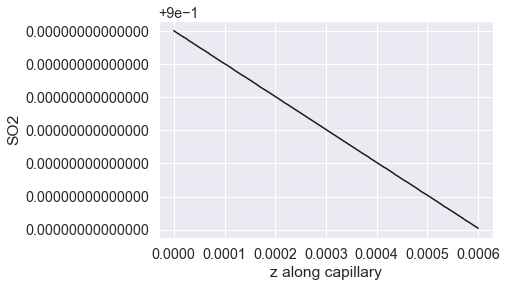

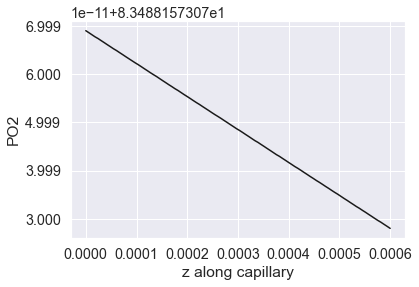

In [59]:

so2_a=0.90


z=np.linspace(0.0,L,100)
so2=so2_a-z*(M0*((Rt**2)-(Rc**2))/(Hct*CHb*v))

po2_c=((so2*(P50**n))/(1-so2))**(1/n)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(z,so2,'k')
plt.xlabel('z along capillary')
plt.ylabel('SO2')
ax.ticklabel_format(style='plain')
#plt.title('SO2 Along the Capillary')
0
plt.figure()
plt.plot(z,po2_c,'k')
plt.xlabel('z along capillary')
plt.ylabel('PO2')
#plt.title('PO2 Along the Capillary')

print(so2)
print(z)

## 3D Surf Plot

Rieger 2015: 
The total concentration of oxygen c is given by

$c= \alpha P + Hc_{0}S(P)$

Where 
H is hematocrit
c0 is the concentration of oxygen in the RBCs at full saturation

$\alpha = \alpha_{p} + H \alpha_{RBC}$

$\alpha$ is the effective solubility in blood and $ \alpha_{p}$ and $\alpha_{RBC}$ are the solubility in plasma and RBCs, respectively. 

and $S(P)=\frac{P^n}{P^n+P^n_{50}}$


From https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2901984/#b38:

$ScapO2=SaO2*(1-\frac{EO2}{2})$

$EO2=\frac{CaO2-CvO2}{CaO2}$

$c= \alpha P + Hc_{0}S(P)$

Text(0.5, 1.0, 'PO2 Along Capillary Length \n For Varied Oxygen Extraction Fraction')

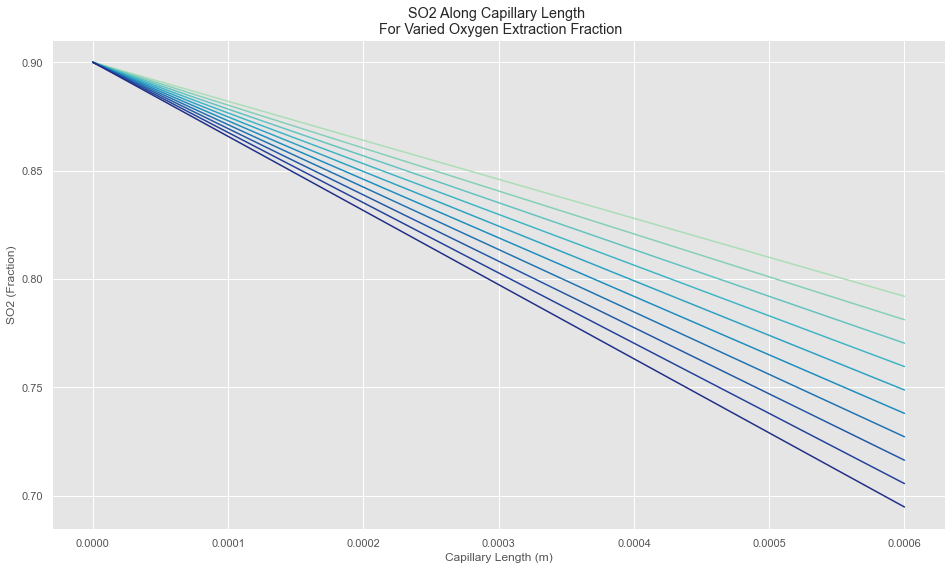

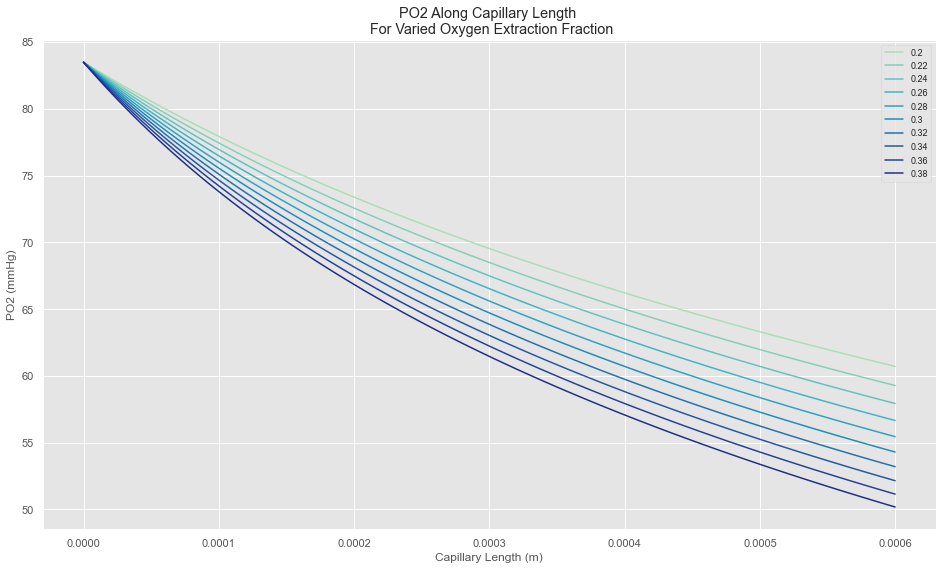

In [169]:
SaO2=0.9

L=0.001
halfL=L/2
length=np.linspace(0,6,100)
z=length/10000
P50=37
n=2.7
plt.style.use('ggplot')
fig = plt.figure()
ax = fig.add_subplot(111)

for j in range(20,40,2):
    OEF=j/100
    Scapmean=SaO2*(1-(OEF/2))
    slope=(Scapmean-SaO2)/halfL
    y=SaO2+slope*z

    plt.plot(z,y,label=OEF)

colormap = plt.cm.YlGnBu #nipy_spectral, Set1,Paired   
colors = [colormap(i) for i in np.linspace(0.3, 0.9,len(ax.lines))]
for i,j in enumerate(ax.lines):
    j.set_color(colors[i])
#plt.legend(fontsize=9,bbox_to_anchor=(1, 1))
plt.xlabel('Capillary Length (m)')
plt.ylabel('SO2 (Fraction)')
plt.title('SO2 Along Capillary Length \n For Varied Oxygen Extraction Fraction')


fig = plt.figure()
ax = fig.add_subplot(111)

for j in range(20,40,2):
    OEF=j/100
    Scapmean=SaO2*(1-(OEF/2))
    slope=(Scapmean-SaO2)/halfL
    y=SaO2+slope*z
    
    
    po2_cap=((y*(P50**n))/(1-y))**(1/n)

    plt.plot(z,po2_cap,label=OEF)

colormap = plt.cm.YlGnBu #nipy_spectral, Set1,Paired   
colors = [colormap(i) for i in np.linspace(0.3, 0.9,len(ax.lines))]
for i,j in enumerate(ax.lines):
    j.set_color(colors[i])
plt.legend(fontsize=9,bbox_to_anchor=(1, 1))
plt.xlabel('Capillary Length (m)')
plt.ylabel('PO2 (mmHg)')
plt.title('PO2 Along Capillary Length \n For Varied Oxygen Extraction Fraction')

In [73]:
Scapmean

0.756

In [77]:
L=0.0006
halfL=L/2

In [76]:
halfL

0.0003

In [78]:
(Scapmean-SaO2)/halfL

-480.0000000000001

In [79]:
slope=(Scapmean-SaO2)/halfL

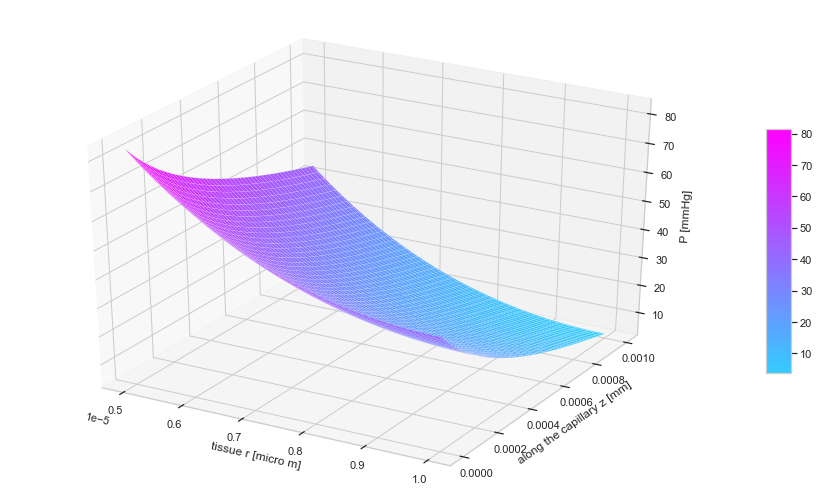

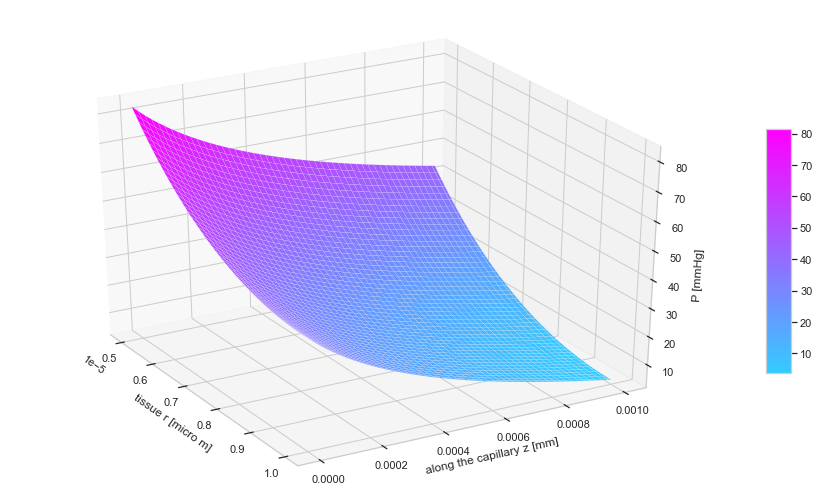

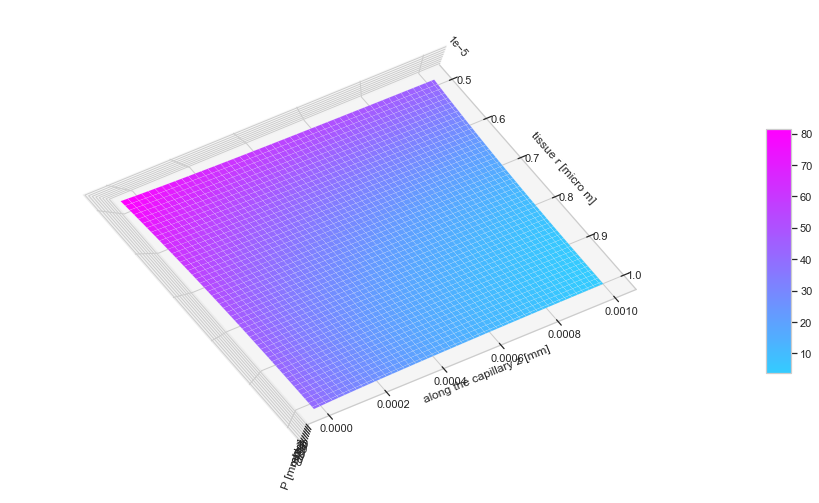

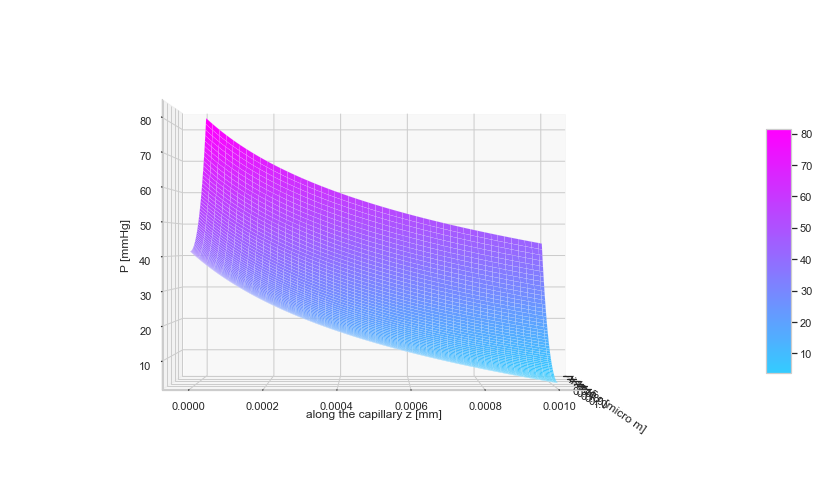

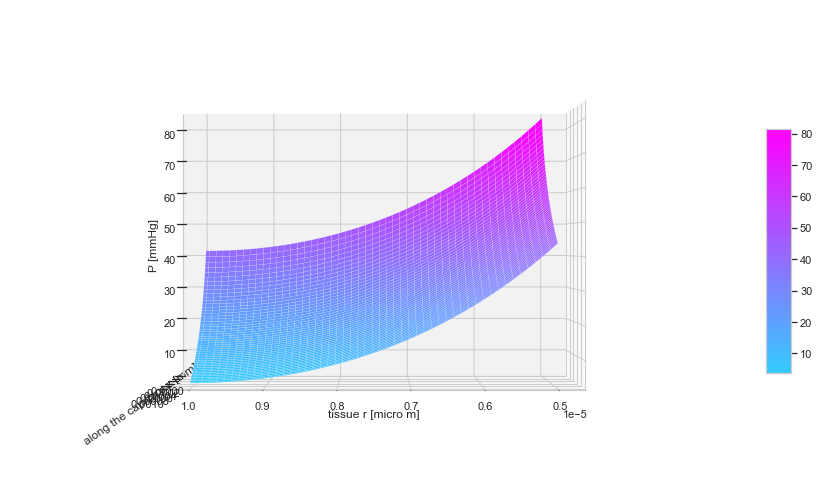

In [171]:
import matplotlib.colors as colors


def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('cool')
new_cmap = truncate_colormap(cmap, 0.2, 1)



Nz = 100;
Nr = 100;

SaO2=0.9

L=0.001
halfL=L/2
length=np.linspace(0,1,Nz)
z=length/1000
P50=37
n=2.7

po2_r_list=np.zeros((Nr,Nz))

OEF =0.32

Scapmean=SaO2*(1-(OEF/2))
slope=(Scapmean-SaO2)/halfL
y=SaO2+slope*z
po2_cap_list=((y*(P50**n))/(1-y))**(1/n)

for i in range(0,Nz):
    po2_cap=po2_cap_list[i]
    
    r_list = np.linspace(Rc,Rt,Nr)
    
    for j in range(0,Nr):
        r=r_list[j]



        M=(M0*po2_cap)/(po2_cap+Pcrit)
        po2_r=po2_cap+((M/(4*K))*(r**(2)-Rc**(2))) - ((M*Rt**2)/(2*K))*(math.log((r/Rc))) # that log is actually ln
        po2_r_list[i,j]=po2_r
    
Psltn=po2_r_list


# Make data.
X = np.linspace(Rc,Rt,Nr)
Y = np.linspace(0, L, Nz)
X, Y = np.meshgrid(X, Y)
Z=Psltn


sns.set(font_scale=1)
sns.set_style("whitegrid")

fig = plt.figure()
plt.rcParams["figure.figsize"] = [16,9]
ax = fig.gca(projection='3d')

surf = ax.plot_surface(X,Y, Z, cmap=new_cmap,
                       linewidth=0.1)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=10)

ax.set_ylabel('along the capillary z [mm]')
ax.set_xlabel('tissue r [micro m]')
ax.set_zlabel('P [mmHg]')


plt.show()



fig = plt.figure()
plt.rcParams["figure.figsize"] = [16,9]
ax = fig.gca(projection='3d')

surf = ax.plot_surface(X,Y, Z, cmap=new_cmap,
                       linewidth=0.1)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=10)

ax.set_ylabel('along the capillary z [mm]')
ax.set_xlabel('tissue r [micro m]')
ax.set_zlabel('P [mmHg]')
ax.view_init(30, -30)

plt.show()



fig = plt.figure()
plt.rcParams["figure.figsize"] = [16,9]
ax = fig.gca(projection='3d')

surf = ax.plot_surface(X,Y, Z, cmap=new_cmap,
                       linewidth=0.1)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=10)

ax.set_ylabel('along the capillary z [mm]')
ax.set_xlabel('tissue r [micro m]')
ax.set_zlabel('P [mmHg]')
ax.view_init(90, -30)

plt.show()


fig = plt.figure()
ax = fig.gca(projection='3d')
plt.rcParams["figure.figsize"] = [16,9]

surf = ax.plot_surface(X,Y, Z, cmap=new_cmap,
                       linewidth=0.1)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=10)

ax.set_ylabel('along the capillary z [mm]')
ax.set_xlabel('tissue r [micro m]')
ax.set_zlabel('P [mmHg]')
ax.view_init(0, 0)

plt.show()


fig = plt.figure()
plt.rcParams["figure.figsize"] = [16,9]
ax = fig.gca(projection='3d')

surf = ax.plot_surface(X,Y, Z, cmap=new_cmap,
                       linewidth=0.1)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=10)

ax.set_ylabel('along the capillary z [mm]')
ax.set_xlabel('tissue r [micro m]')
ax.set_zlabel('P [mmHg]')
ax.view_init(0,90)

plt.show()


In [190]:
np.mean(Psltn)
np.shape(Psltn)

(100, 100)

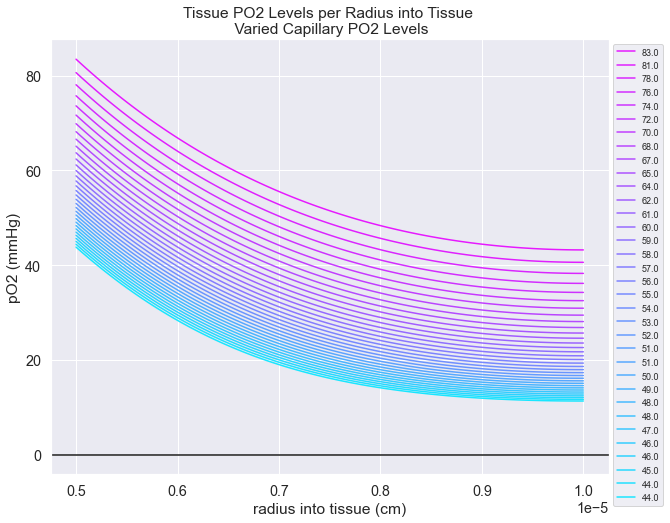

In [174]:
r_list = np.linspace(Rc,Rt,100)
plt.style.use('ggplot')
sns.set(font_scale=1.3)

Mlist=np.zeros((100,20))

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)

for j in range(0,Nz,3):
    for i in range(0,len(r_list)):
        r=r_list[i]
        po2_c=po2_cap_list[j]
        
        if i==0:
            M=(M0*po2_c)/(po2_c+Pcrit)
            po2_r=po2_c+((M/(4*K))*(r**(2)-Rc**(2))) - ((M*Rt**2)/(2*K))*(math.log((r/Rc))) # that log is actually ln

        if i>0:
            if po2_r>Pcrit:
                M=(M0*po2_r)/(po2_r+Pcrit)
                po2_r=po2_c+((M/(4*K))*(r**(2)-Rc**(2))) - ((M*Rt**2)/(2*K))*(math.log((r/Rc))) # that log is actually ln
            if po2_r<=Pcrit:
                po2_r=Pcrit
        po2_list[i]=po2_r

    plt.plot(r_list,po2_list,label=np.round(po2_c))


colormap = plt.cm.cool_r #nipy_spectral, Set1,Paired   
colors = [colormap(i) for i in np.linspace(0.1, 0.9,len(ax.lines))]
for i,j in enumerate(ax.lines):
    j.set_color(colors[i])
plt.axhline(color='k')

plt.title('Tissue PO2 Levels per Radius into Tissue \n Varied Capillary PO2 Levels')
plt.xlabel('radius into tissue (cm)')
plt.ylabel('pO2 (mmHg)')
plt.legend(fontsize=9,bbox_to_anchor=(1, 1))

In [93]:
z

array([0.00000000e+00, 6.06060606e-06, 1.21212121e-05, 1.81818182e-05,
       2.42424242e-05, 3.03030303e-05, 3.63636364e-05, 4.24242424e-05,
       4.84848485e-05, 5.45454545e-05, 6.06060606e-05, 6.66666667e-05,
       7.27272727e-05, 7.87878788e-05, 8.48484848e-05, 9.09090909e-05,
       9.69696970e-05, 1.03030303e-04, 1.09090909e-04, 1.15151515e-04,
       1.21212121e-04, 1.27272727e-04, 1.33333333e-04, 1.39393939e-04,
       1.45454545e-04, 1.51515152e-04, 1.57575758e-04, 1.63636364e-04,
       1.69696970e-04, 1.75757576e-04, 1.81818182e-04, 1.87878788e-04,
       1.93939394e-04, 2.00000000e-04, 2.06060606e-04, 2.12121212e-04,
       2.18181818e-04, 2.24242424e-04, 2.30303030e-04, 2.36363636e-04,
       2.42424242e-04, 2.48484848e-04, 2.54545455e-04, 2.60606061e-04,
       2.66666667e-04, 2.72727273e-04, 2.78787879e-04, 2.84848485e-04,
       2.90909091e-04, 2.96969697e-04, 3.03030303e-04, 3.09090909e-04,
       3.15151515e-04, 3.21212121e-04, 3.27272727e-04, 3.33333333e-04,
      

In [96]:
y=SaO2+slope*z

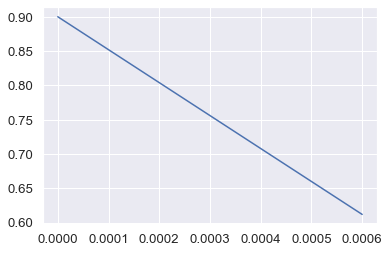

In [97]:
plt.plot(z,y)